In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pg import DB
import configparser
import preprocess
import plotting_functions
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# CONNECTION SET UP
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']

db = DB(dbname=dbset['database'],host=dbset['host'],user=dbset['user'],passwd=dbset['password'])

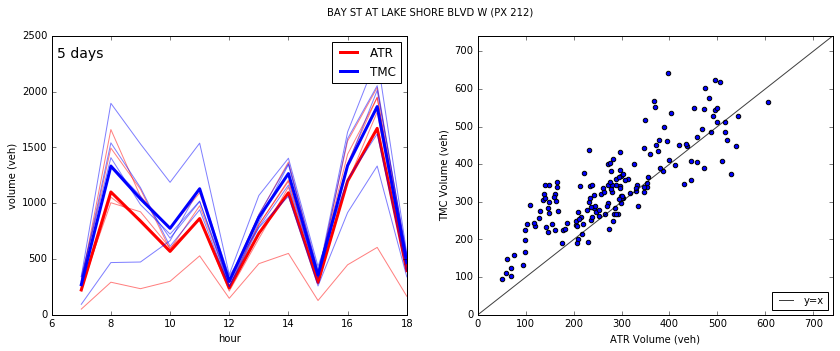

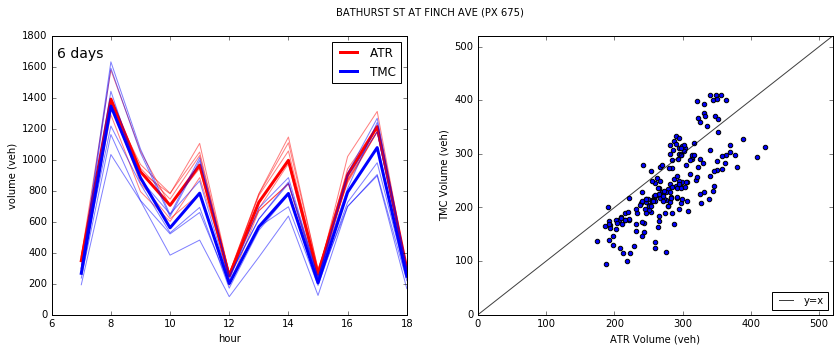

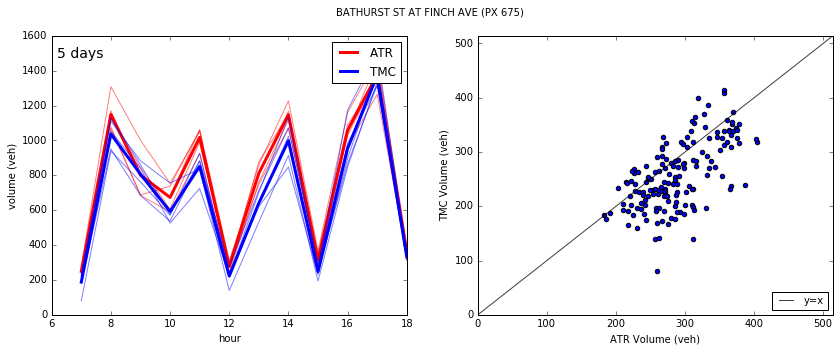

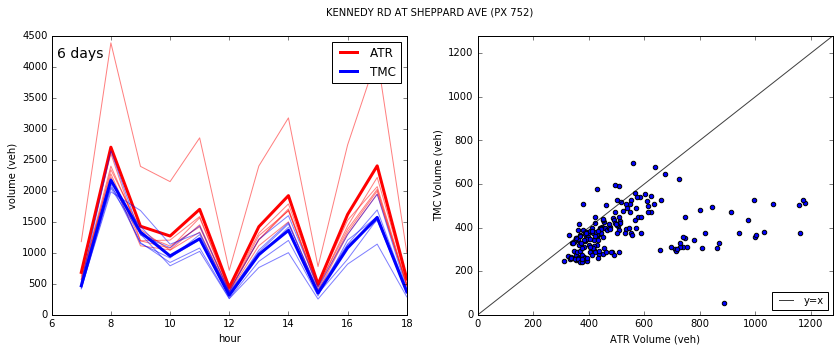

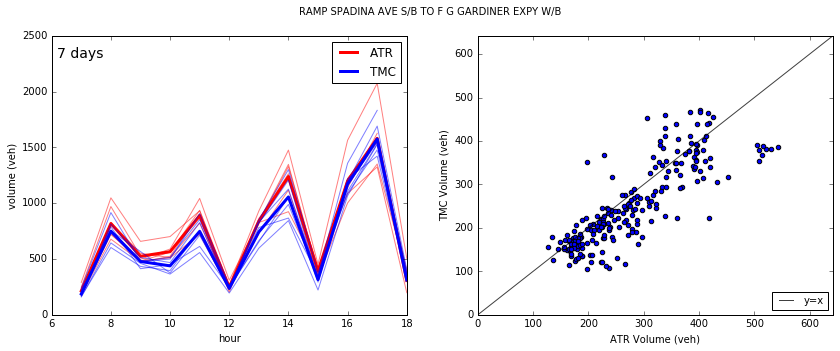

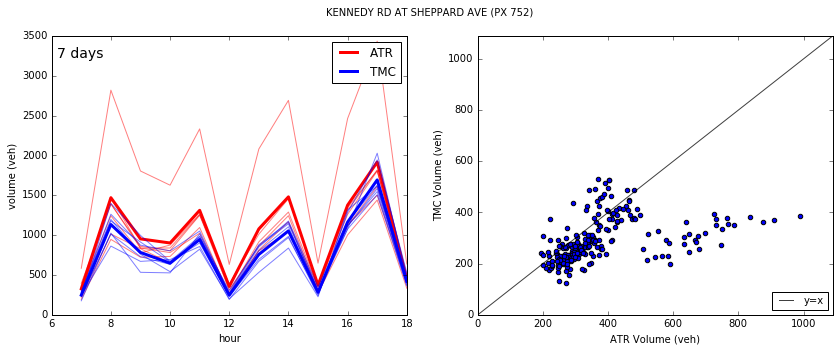

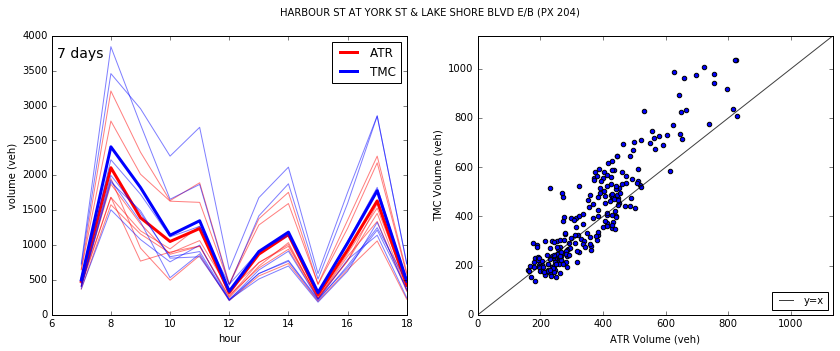

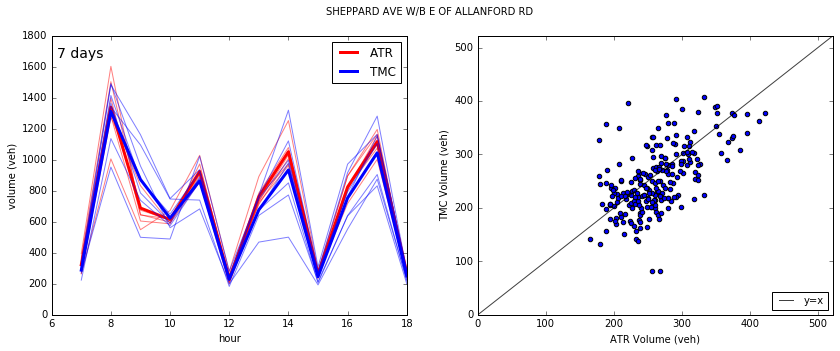

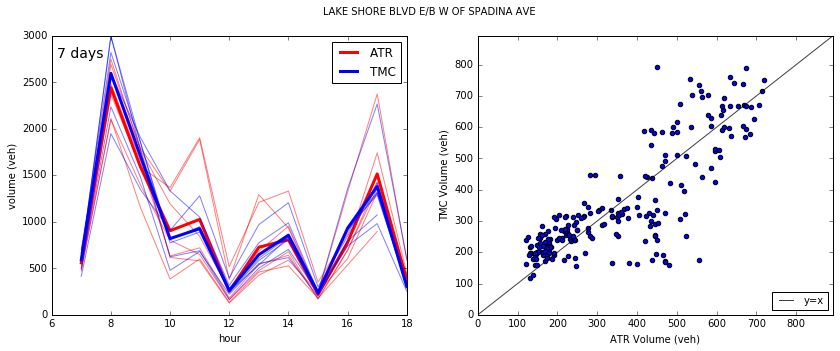

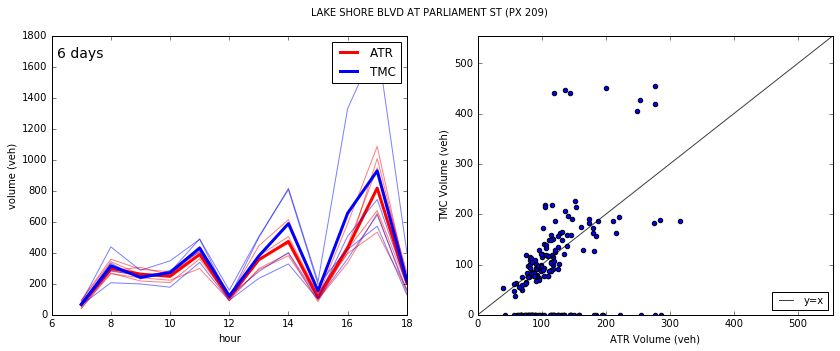

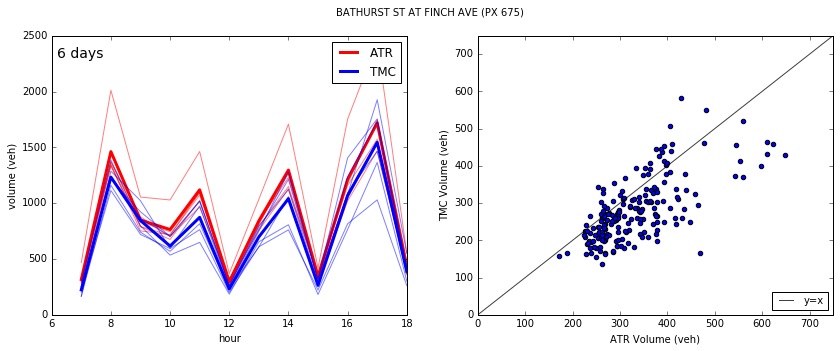

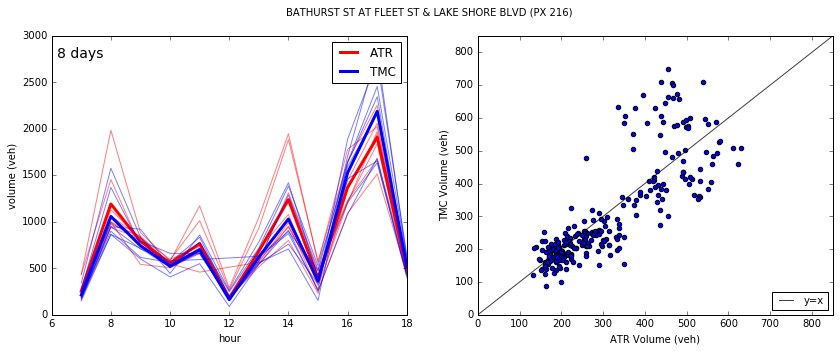

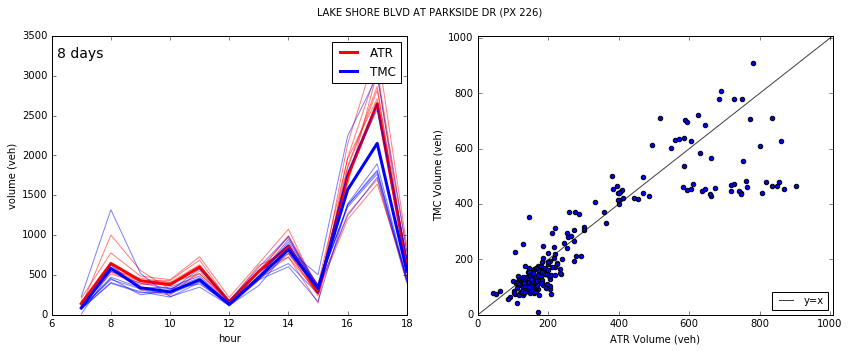

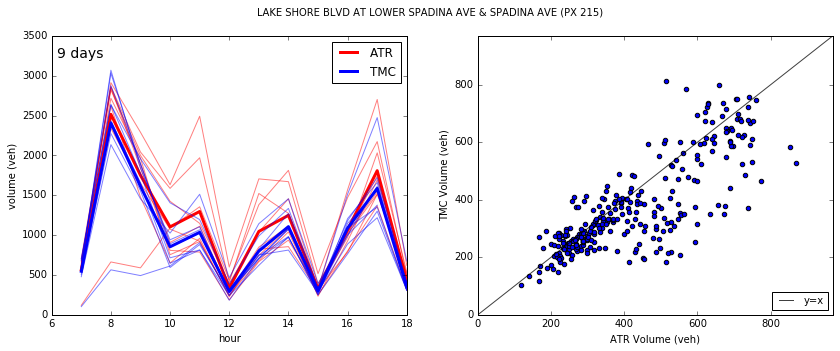

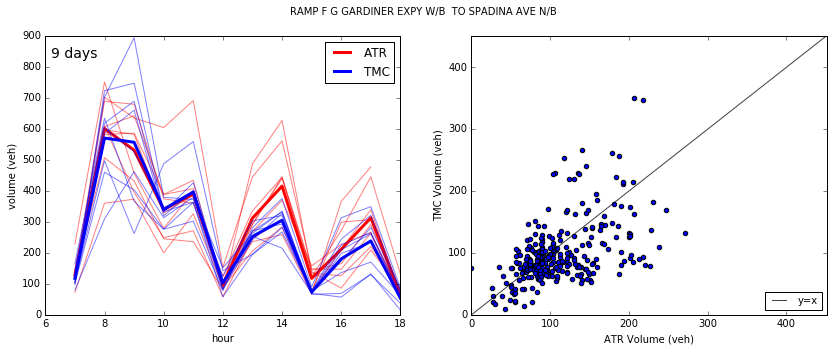

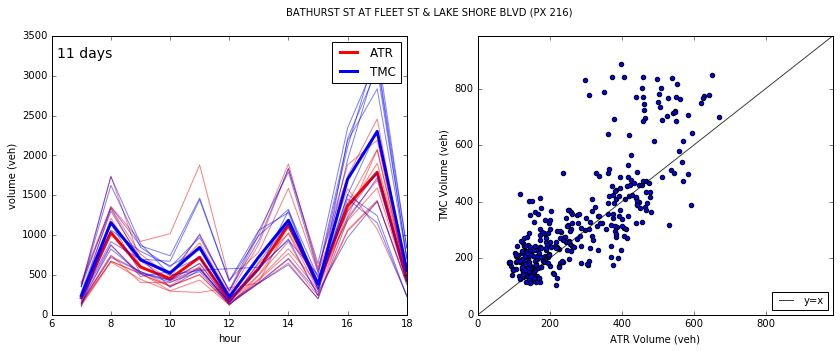

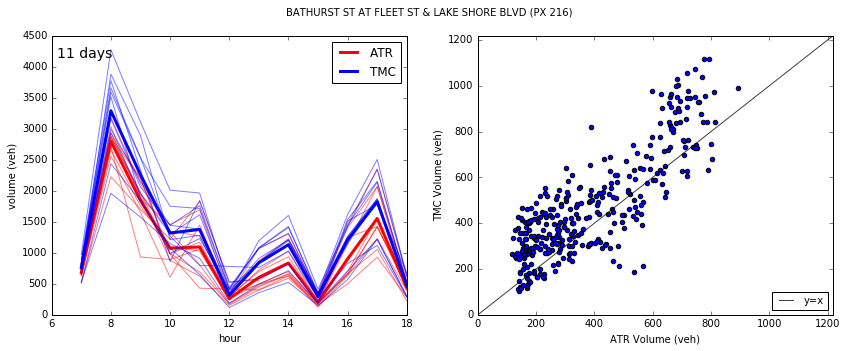

In [9]:
centrelines = [(1146615,-1),(11129605,-1),(5849817,1),(9637988,-1),(12334937,-1),(9668534,1),(5866210,1),(106971,-1),(30082883,1),(8396807,1),(438481,1),(8491741,-1),(13515818,-1),(1147026,1),(12334940,-1),(1147201,-1),(1147201,1)]
for (tcl,dirc) in centrelines:
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=[14,5])
    
    location = db.query('SELECT location FROM prj_volume.artery_tcl JOIN traffic.arterydata USING (arterycode) WHERE centreline_id = ' + str(tcl)).getresult()[0][0]
    fig.suptitle(location)
    
    dataT = pd.DataFrame(db.query('SELECT centreline_id, count_bin, volume, dir_bin, speed_class FROM prj_volume.centreline_volumes WHERE centreline_id = ' + str(tcl) + ' AND dir_bin = ' + str(dirc) + ' AND count_type = 2').getresult(), columns = ['centreline_id','count_bin','volume','dir_bin','speed_class'])
    dataT = dataT.groupby(['centreline_id','count_bin','dir_bin'], as_index=False).sum()
    preprocess.preprocess_flow(dataT,'')
    maxdate = max(dataT['date'])
    mindate = min(dataT['date'])
    
    dataA = pd.DataFrame(db.query("SELECT centreline_id, count_bin, volume, dir_bin, speed_class FROM prj_volume.centreline_volumes WHERE centreline_id = " + str(tcl) + " AND dir_bin = " + str(dirc) + " AND count_type = 1 AND count_bin <= \'" + str(maxdate) + "\' AND count_bin >= \'" + str(mindate) +"/'").getresult(), columns = ['centreline_id','count_bin','volume','dir_bin','speed_class'])
    dataA = dataA.groupby(['centreline_id','count_bin','dir_bin'], as_index=False).sum()
    preprocess.preprocess_flow(dataA,'')

    dataA = dataA.merge(dataT, how = 'inner', on = ['centreline_id','dir_bin','date','time_15'])

    ancounts, aavg, andays = plotting_functions.TOD(ax1,dataA,'centreline_id','dir_bin','date','volume_x',(tcl,dirc),['r'],False,'ATR')
    tncounts, tavg, tndays = plotting_functions.TOD(ax1,dataA,'centreline_id','dir_bin','date','volume_y',(tcl,dirc),['b'],False,'TMC')
    
    (x1,x2) = ax1.get_xlim()
    (y1,y2) = ax1.get_ylim()
    ax1.annotate(str(andays)+' days', xy=(x1*1.03, y2*0.92), fontsize = 14)
    ax1.legend()

    ax2.scatter(dataA['volume_x'], dataA['volume_y'], label = None)
    
    ax2.set_xlim([0,max(max(dataA['volume_x']),max(dataA['volume_y']))+100])
    ax2.set_ylim([0,max(max(dataA['volume_x']),max(dataA['volume_y']))+100])
    
    # Add y=x
    lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
    ]
    ax2.plot(lims, lims, 'k-', alpha=0.75, label = 'y=x')
    ax2.legend(loc=4,fontsize=10)
    
    # axes labels
    ax2.set_xlabel('ATR Volume (veh)')
    ax2.set_ylabel('TMC Volume (veh)')
    
    plt.show()   

In [10]:
db.close()